# Exploratory Data Analysis and Data Cleaning

The `librosa` package for audio processing and visualisation is used throughout our work. See https://librosa.org/doc/latest/index.html# for more information.

In [3]:
import librosa, librosa.display 
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import math

## Metadata

The data we obtained from XXXX came in the form of 12602 .wav files of varying lengths, with an accompanying metadata .csv file containing the following information:
- Biological classification (genus, species).
- Recording information (recordist, date, apparatus used, geographical location, etc.).

To make the biological information more comprehensive, we added information on subfamilies(??) and families (??) to the metadata file.

(Add stuff from adding_fam_or_subfam.ipynb)

## Removing Human Speech

Many of the files contained a human speech component at the beginning (the recordist or cataloguing scientist stating the index number of the recording, for instance). We used the following code to extract the second non-silent chunk of each audio file, which typically contained a useful section of the insect sound recording.

In [4]:
def remove_Talking(f):
    chirp_song, sr = librosa.load(f)
    split=librosa.effects.split(chirp_song, top_db=60)
    chirp_song_split=chirp_song[split[1,0]:split[1,1]]
    if chirp_song_split.shape[0] > 220500:
        chirp_song_split = chirp_song_split[:220500]
    return chirp_song_split

Further EDA revealed that even after the initial human speech component was eliminated, some audio files still contained human speech. The following code located these audio files and removed them from our analysis.

In [5]:
SAMPLING_RATE = 16000

import torch
torch.set_num_threads(1)

from IPython.display import Audio
from pprint import pprint

model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True,
                              onnx=False)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

SAMPLING_RATE=16000
wav = read_audio('E://Chirp_Files/117596.wav', sampling_rate=SAMPLING_RATE)
# get speech timestamps from full audio file
speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=SAMPLING_RATE)
pprint(speech_timestamps)

import sys
sys.path.append('E://Chirp_Files')

import os
# assign directory
directory = 'E://Chirp_Files'
no_voice_files=[]
voice_files=[]

# iterate over files in
# that directory
n = 0
m = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        n+=1
        m+=1
        wav = read_audio(f, sampling_rate=SAMPLING_RATE)
        speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=SAMPLING_RATE)
        if speech_timestamps == []:
            no_voice_files.append(f)
        else:
            voice_files.append(f)
        if n % 100 == 0:
            print(m)
            n = 0
            df = pd.DataFrame(voice_files)
            df.to_csv("voice_files.csv", header=False, index=False)
            df = pd.DataFrame(no_voice_files)
            df.to_csv("no_voice_files.csv", header=False, index=False)

ModuleNotFoundError: No module named 'torch'

Out of the 12602 audio files remaining after `remove_Talking` was applied, this reduced the size of our data set to 6122. The final data set used in training and testing the model is `no_voice_files.csv`.

## Data Visualisation

Librosa has built in code for plotting spectographs in the linear and log scales. We primarily graphed in log scales

In [10]:
def plot_spectogram(DB):
#plotting a spectogram from an array containing with (i,j) entry the decibells at frequency i time j in the log scale
    librosa.display.specshow(DB, y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB');
    plt.ylim(800,10000)
    plt.show()
    return None

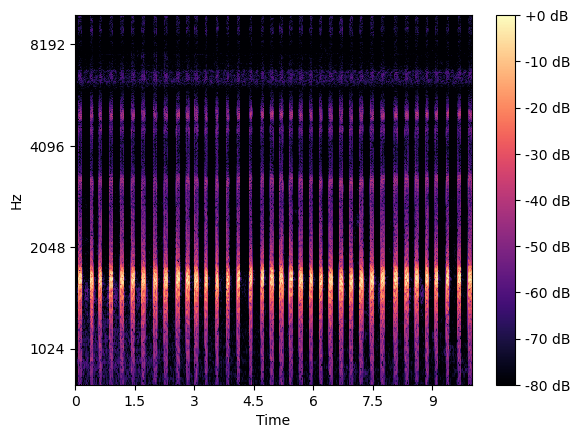

In [16]:
n_fft = 2047
hop_length = 1024
file = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk/534519.wav'
chirp_song, sr = librosa.load(file)
D = np.abs(librosa.stft(chirp_song, n_fft=n_fft,  hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
plot_spectogram(DB)

## Reducing Background Noise

The next step was to clean the audio of any further background noise. Since crickets, cicadas, and katydids typically chirp at frequencies in the 2-10kHz range, we used the following code to remove frequencies below 800Hz from the audio. 

In [ ]:
def remove_low_freq(song, cutoff = 800):
    D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
    cut = int(float(cutoff)/(librosa.fft_frequencies()[1]))
    D = D[cut:]
    return D

Our other method of reducing background noise was to subtract the median decibells at each frequency from the entire spectograph. This way any constant background noise is reduced to nothing

In [1]:
def clean_DB(DB):
    DBclean = np.zeros(DB.shape)
    for x in range(0,DB.shape[0]):
        med = np.median(DB[x, :])
        DBclean[x, :] = DB[x, :]-med
    return DBclean

In some files this worked well at highlighting insect chirps (in the second plot the chirps are in red).

spectogram:


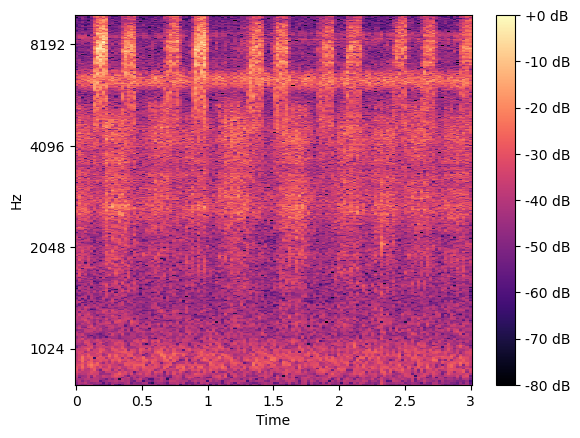

cleaned spectogram:


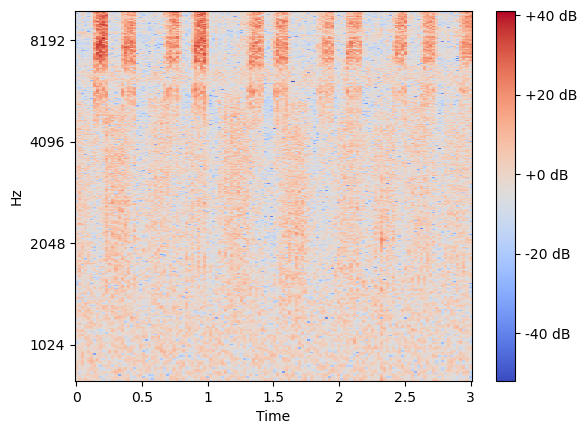

In [36]:
file = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk/118344.wav'
chirp_song, sr = librosa.load(file)
chirp_song = chirp_song[0+22050:132300+22050]
D = np.abs(librosa.stft(chirp_song, n_fft=n_fft,  hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
print('spectogram:')
plot_spectogram(DB)
print('cleaned spectogram:')
plot_spectogram(clean_DB(DB))

But in some instances where the insect was making a more constant noise it removed the sounds we wanted to record!

spectogram:


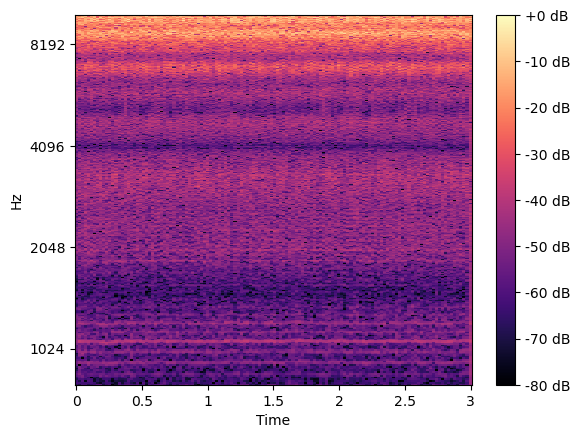

cleaned spectogram:


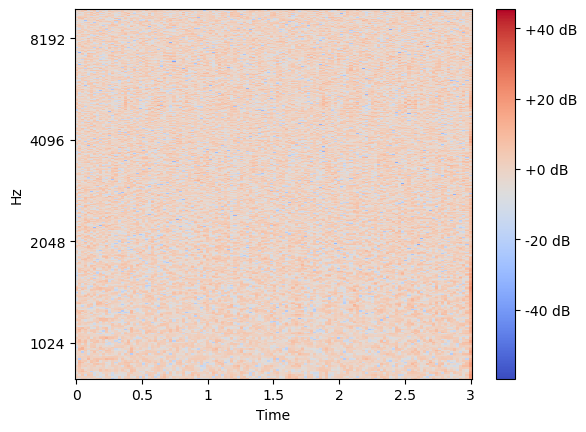

In [35]:
file = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk/84657.wav'
chirp_song, sr = librosa.load(file)
chirp_song = chirp_song[0+22050:132300+22050]
D = np.abs(librosa.stft(chirp_song, n_fft=n_fft,  hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
print('spectogram:')
plot_spectogram(DB)
print('cleaned spectogram:')
plot_spectogram(clean_DB(DB))

When we extract data, you will see we used data points both correponding to uncleaned and cleaned data. For example, when finding the predominant frequency in a insects song, we calculate two frequncies: the one with the highest mean decibells (an uncleaned data point) and the one with the highest variance (a cleaned data point).

## Feature Extraction

(Fill in science-y stuff about MFCCs and LFCCs and why we use them.)

The following code extracts MFCCs from the audio files used.

In [ ]:
no_voice_list = pd.read_csv('no_voice_files.csv', header=None)
filename_list = [name.split("\\")[-1] for name in no_voice_list[0]]

df = pd.read_csv('MLNS_Insects_Fams_05212024.csv')

#This creates the new CSV with mfcc coefficients and f_min cuttoff = 800. Ignores files with length < .5 seconds. No need to run since the csv is now in the git!
ct = 0
n= 40
for name in filename_list:
    
    #change this file path to the chirp_bucket_2 folder
    file_path = '../../../chirp/'+name
    song, sr = librosa.load(file_path)
    if song.shape[0] > sr/2:
        lib = librosa.feature.mfcc(y=song, sr=sr, fmin = 800, n_mfcc=n)
        for i in range(0,n):
            df.at[df.loc[df['cat_num']==int(name[:-4])].index[0], 'mfcc_'+str(i)+'_avg'] = lib[i].mean()
            df.at[df.loc[df['cat_num']==int(name[:-4])].index[0], 'mfcc_'+str(i)+'_var'] = lib[i].var()
           # df['mfcc_'+str(i)+'_avg']=lib[i].mean()
           # df['mfcc_'+str(i)+'_var']=lib[i].var()
        ct+=1
        if ct % 100 == 0:
            df.to_csv("MLNS_with_mfcc_stats_800_cutoff_05272024.csv")